This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,
 * calculates the central noise level
 * calculates tniti

In [1]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import component_separation.MSC.MSC.pospace as ps

from lerepi.data.dc08 import data_08d as sims_if
sims  = sims_if.ILC_May2022('00')
from lerepi.survey_config.dc08 import sc_08d as sc


simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

MSC: reverting to standard healpy


ModuleNotFoundError: No module named 'lerepi.survey_config'

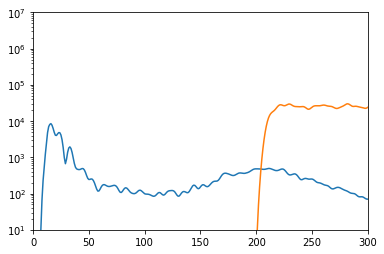

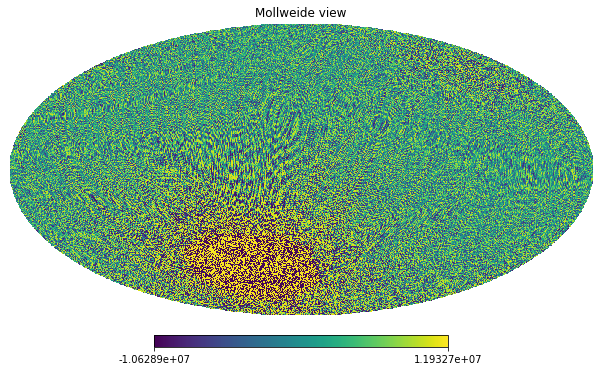

In [56]:
elm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_07_lmax4000/ivfsOBD/sim_0001_elm.fits')
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_07_lmax4000/ivfsOBD/sim_0001_blm.fits')
plt.plot(hp.alm2cl(elm), label='ClEE')
plt.plot(hp.alm2cl(blm), label='ClBB')
plt.yscale('log')
plt.ylim(1e1,1e7)
plt.xlim(0,300)
plt.show()
bmap = hp.alm2map(blm, nside=2048)
hp.mollview(bmap, norm='hist')

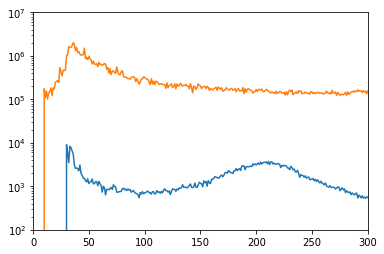

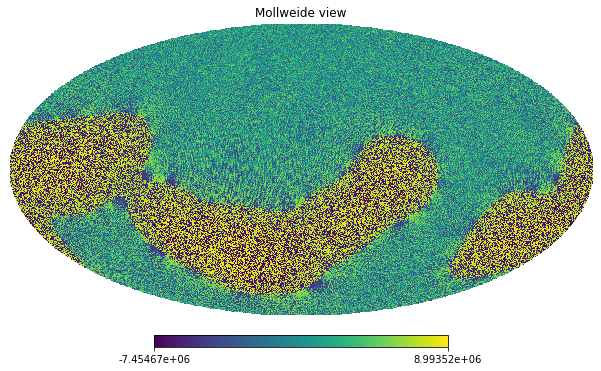

In [58]:
elm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/ivfs/sim_0001_elm.fits')
blm = hp.read_alm('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/ivfs/sim_0001_blm.fits')
plt.plot(hp.alm2cl(elm), label='ClEE')
plt.plot(hp.alm2cl(blm), label='ClBB')
plt.yscale('log')
plt.ylim(1e2,1e7)
plt.xlim(0,300)
plt.show()
bmap = hp.alm2map(blm, nside=2048)
hp.mollview(bmap, norm='hist')

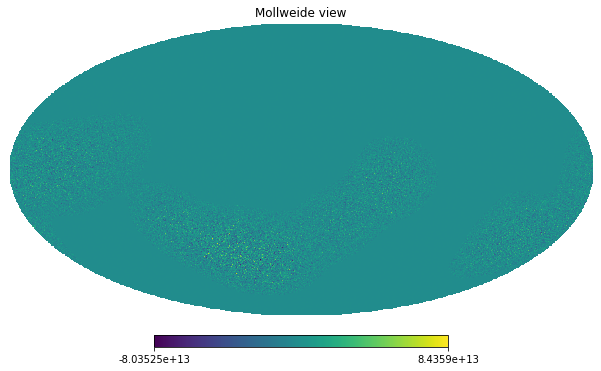

In [53]:
mf = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/p_p_sim0000/mf.npy')
hp.mollview(hp.alm2map(mf, nside=2048))#, norm='hist')

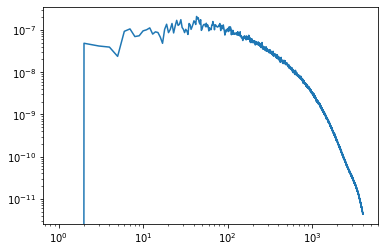

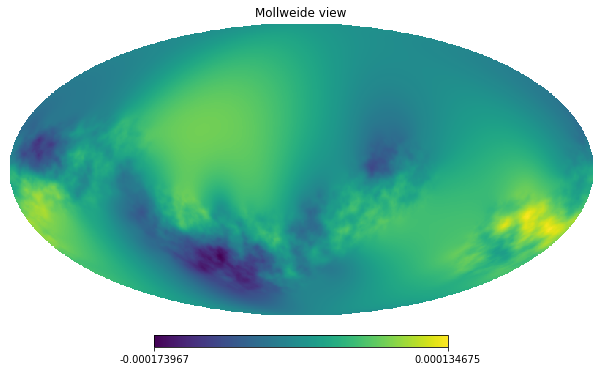

In [49]:
plm = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/p_p_sim0000/phi_plm_it000.npy')
plm_08b = np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/p_p_sim0000/phi_plm_it000.npy')
plt.plot(hp.alm2cl(plm)*np.arange(4001)**4)
plt.yscale('log')
plt.xscale('log')
hp.mollview(hp.alm2map(plm, nside=2048))

In [60]:
wflm = np.array([np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/p_p_sim0000/wflms/wflm_p_it%s.npy'%it) for it in range(7)])

(1e-07, 0.001)

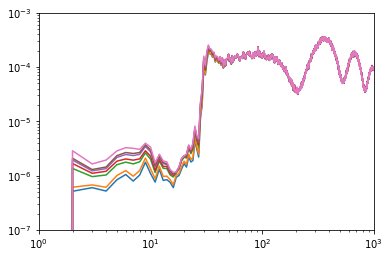

In [77]:
for n in range(7):
    plt.plot(hp.alm2cl(wflm[n]))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,1e3)
plt.ylim(1e-7,1e-3)

In [90]:
from lenscarf.iterators.statics import rec as rec
libdir_iterator = '/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/p_p_sim0000/'
plms = rec.load_plms(libdir_iterator, [0,1,2,3,4,5,6,7,8,9])

(1e-09, 1e-05)

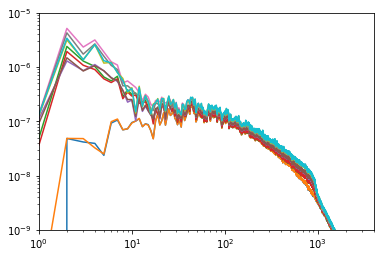

In [91]:
for n in range(len(plms)):
    pcl = hp.alm2cl(plms[n])
    plt.plot(pcl*np.arange(len(pcl))**4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,4e3)
plt.ylim(1e-9,1e-5)

In [84]:
pmaps = np.array([hp.alm2map(plm, nside=2048) for plm in plms])

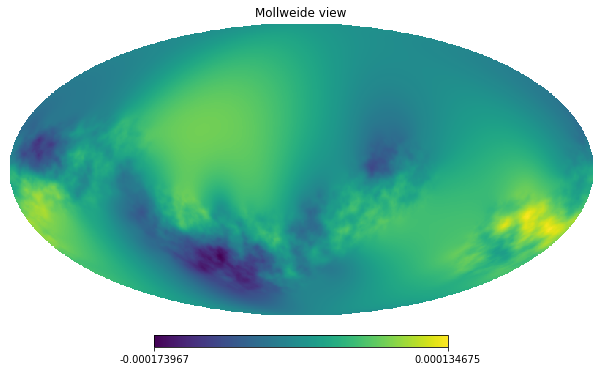

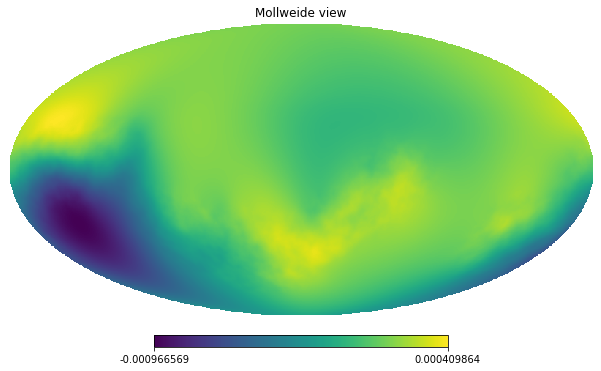

In [86]:
hp.mollview(pmaps[0])
hp.mollview(pmaps[-1])

In [3]:
btemps = np.array([np.load('/global/cscratch1/sd/sebibel/cmbs4/08d_00_r50_MF2/p_p_sim0000/wflms/btempl_p00%s_e00%s_lmax1024.npy'%(it, it)) for it in range(1,9)])

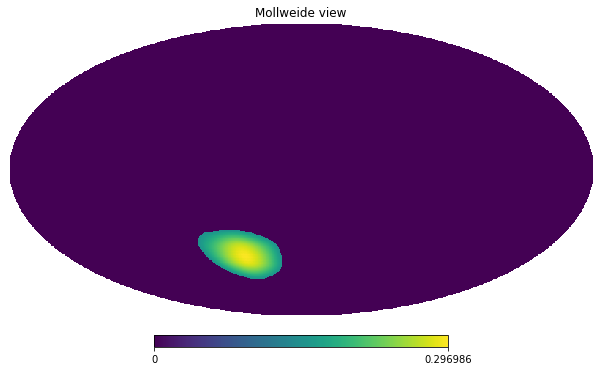

In [28]:
mask = hp.read_map('/global/homes/s/sebibel/git/lerepi/lerepi/data/dc08/masks/mask_r2.fits')
hp.mollview(mask)

In [29]:
print(sum(mask)/len(mask))

0.004829205203795557


In [11]:
btempmap1 = hp.alm2map(btemps[1], nside=2048)
# btempmap = hp.alm2map(btemps[-1], nside=2048)
# btempmap3 = hp.alm2map(btemps[3], nside=2048)

In [5]:
from plancklens import utils
from plancklens.sims import planck2018_sims
beam = 2.3
lmax_transf = 4000
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)

blm_L_buff = hp.almxfl(utils.alm_copy(planck2018_sims.cmb_len_ffp10.get_sim_blm(0), lmax=4000), transf)
bmap_L_buff = hp.alm2map(blm_L_buff, 2048)


In [19]:
Bpurelenscl = hp.anafast(bmap_L_buff*mask, lmax=1000)

In [20]:
btl_diff = hp.anafast(bmap_L_buff*mask-btempmap, lmax=1000)
btl_diff1 = hp.anafast(bmap_L_buff*mask-btempmap1, lmax=1000)
btl_diff3 = hp.anafast(bmap_L_buff*mask-btempmap3, lmax=1000)

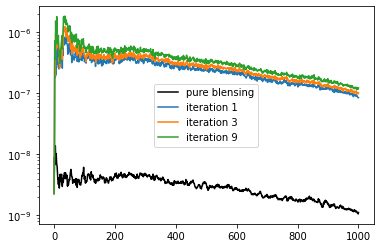

In [22]:
plt.plot(Bpurelenscl, color='black', label='pure blensing')
plt.plot(btl_diff1, label='iteration 1')
plt.plot(btl_diff3, label='iteration 3')
plt.plot(btl_diff, label='iteration 9')
plt.legend()

# plt.xlim(0,300)
# plt.ylim(1e-7,1e-5)
plt.yscale('log')

# Check tniti

In [11]:
tniti_08d = np.load('/global/cscratch1/sd/sebibel/cmbs4/s08d/OBDmatrix/OBD/tniti.npy')

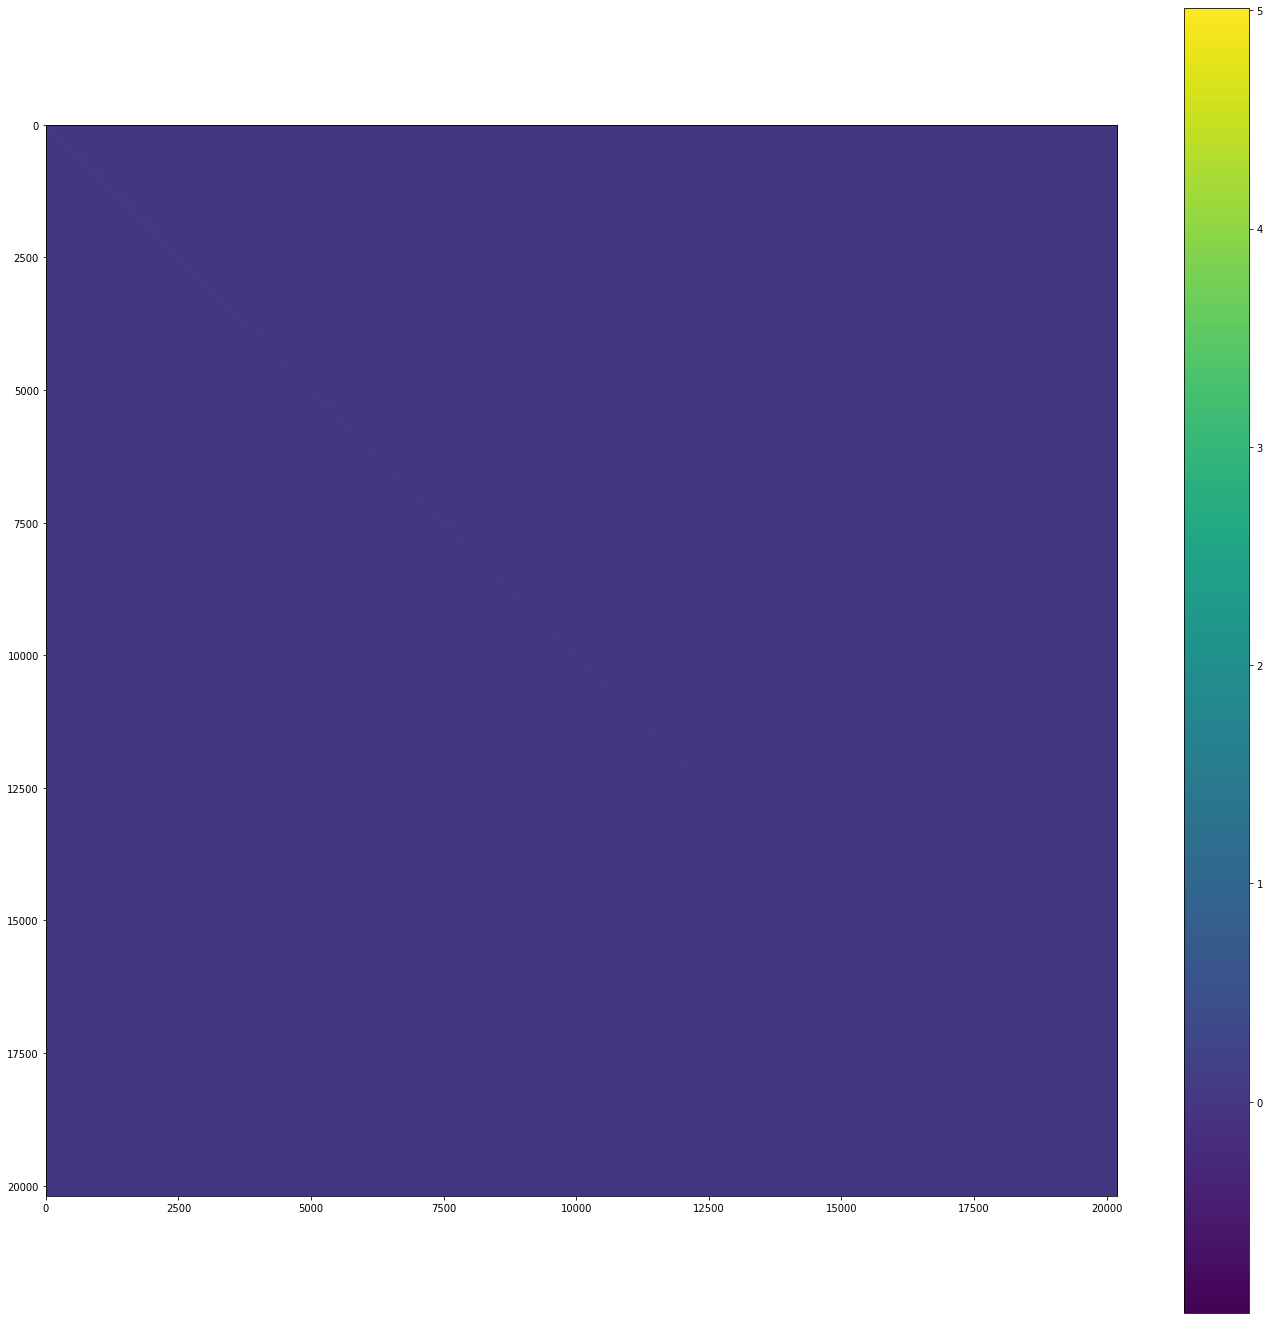

In [12]:
plt.figure(figsize=(24,24))
plt.imshow(tniti_08d[::2,::2])
plt.colorbar()

In [2]:
tniti_08b =  np.load('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08b/tniti.npy')

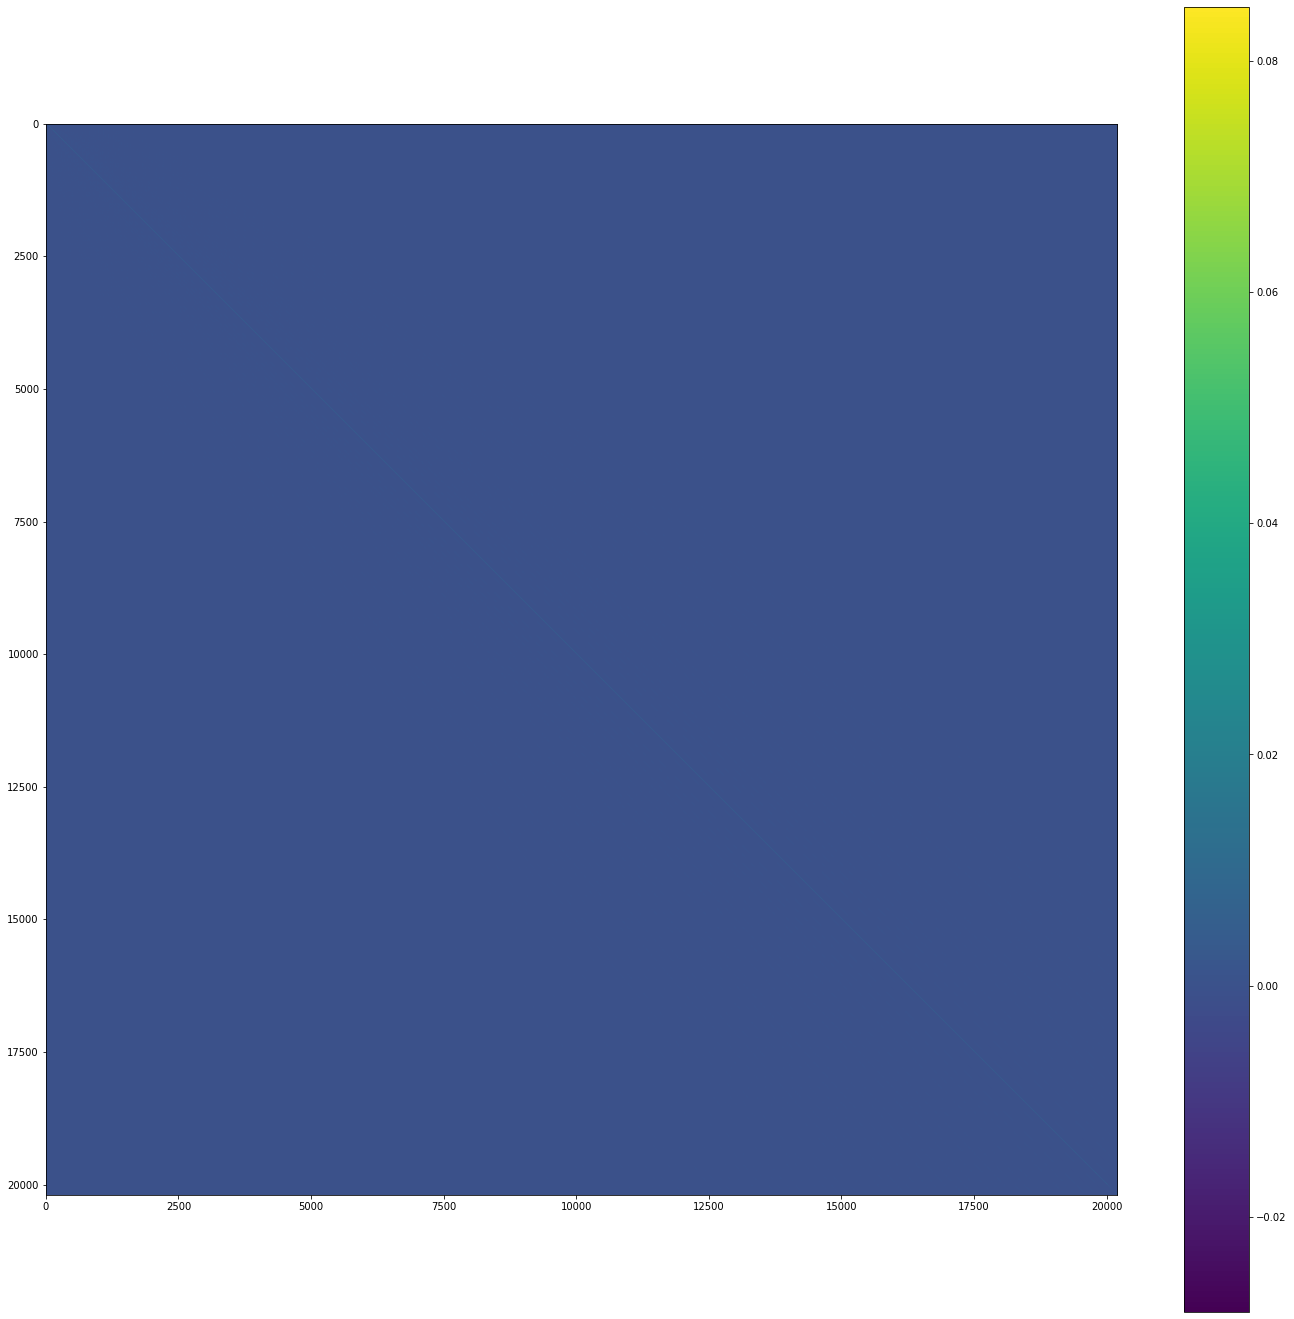

In [7]:
plt.figure(figsize=(24,24))
plt.imshow(tniti_08b[::2,::2])
plt.colorbar()

Text(0, 0.5, 'val')

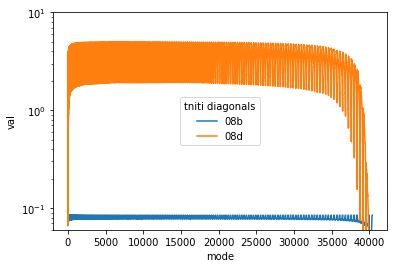

In [21]:
plt.plot(np.diag(tniti_08b),label='08b')
plt.plot(np.diag(tniti_08d), label='08d')
plt.legend(title='tniti diagonals')
plt.yscale( 'log')
plt.ylim(6e-2,1e1)
plt.xlabel('mode')
plt.ylabel('val')

# Check mask

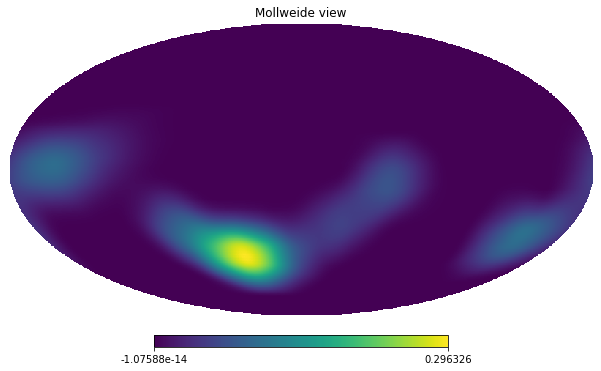

In [5]:
mask = sims_lerepi.get_mask()
hp.mollview(mask)

# Display maps / noise

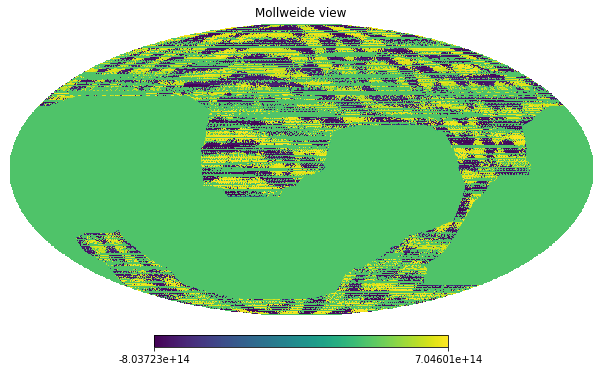

In [8]:
q, u = sims_lerepi.get_sim_pmap(0)
hp.mollview(q, norm='hist')

In [6]:
Cl = ps.map2cl_spin([q,u], spin=2, mask=mask, lmax=lmax-1, lmax_mask=lmax)

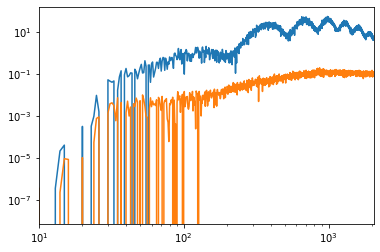

In [21]:
plt.plot(Cl[0]*scale_ps)
plt.plot(Cl[1]*scale_ps)
plt.xlim(10,2048)
plt.xscale('log')
plt.yscale('log')

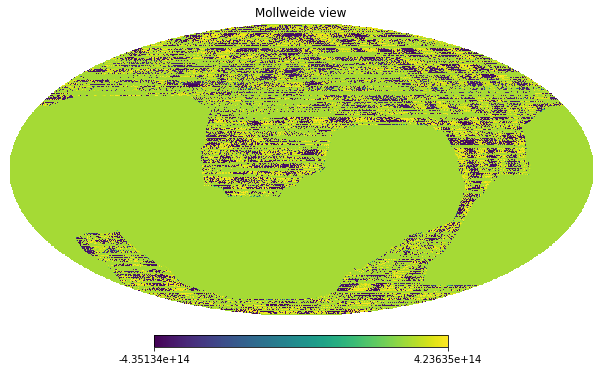

In [24]:
Nq, Nu = sims_lerepi.get_noise_sim_pmap(0)
hp.mollview(Nq, norm='hist')

In [27]:
ClN = ps.map2cl_spin([Nq,Nu], spin=2, mask=mask, lmax=lmax, lmax_mask=lmax)

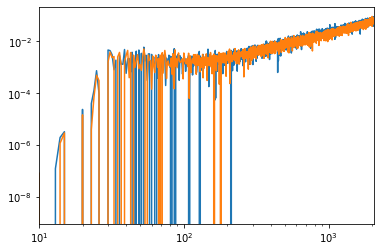

In [28]:
plt.plot(ClN[0]*scale_ps)
plt.plot(ClN[1]*scale_ps)
plt.xlim(10,2048)
plt.xscale('log')
plt.yscale('log')

# Derive transferfunction

In [253]:
beam = 2.3
lmax_transf = 2048
tf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf) * hp.pixwin(2048, lmax=lmax_transf)

In [30]:
def TEBlm_f(simidx):
    '''
    Returns fiducial ffp10 powerspectrum
    '''
    ffp10scalmTEB = 1e6 * hp.read_alm('/project/projectdirs/cmb/data/generic/cmb/ffp10/mc/scalar/ffp10_lensed_scl_cmb_000_alm_mc_%04d.fits'%simidx, hdu=(1,2,3))
    return ffp10scalmTEB

tebmap_f = np.array([hp.alm2map(TEBlm_f(simidx), nside=2048, pol=False) for simidx in simids]) # almTEB -> mapTEB

In [63]:
ClEE_f = ps.map2cl(tebmap_f[0,1], mask=mask, lmax=lmax, lmax_mask=lmax)
ClBB_f = ps.map2cl(tebmap_f[0,2], mask=mask, lmax=lmax, lmax_mask=lmax)

In [ ]:
Cl_fxD = ps.map2cl(tebmap_f[0,1]-, mask=mask, lmax=lmax, lmax_mask=lmax)

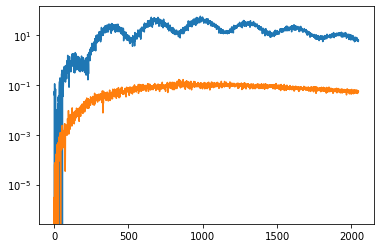

In [64]:
plt.plot(ClEE_f*scale_ps)
plt.plot(ClBB_f*scale_ps)
plt.yscale('log')

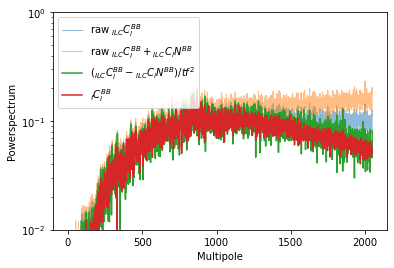

In [105]:
plt.plot(Cl[1]*scale_ps, label=r'raw $_{ILC}C_l^{BB}$', lw=1, alpha=0.5)
plt.plot((Cl[1]+ClN[1])*scale_ps, label=r'raw $_{ILC}C_l^{BB}+_{ILC}C_lN^{BB}$', lw=1, alpha=0.5)
# plt.plot(1/tf**2, label=r"$Tf^{2'3''}_p$")

plt.plot((Cl[1]-ClN[1])*scale_ps/tf[:2048]**2, label=r'$(_{ILC}C_l^{BB} -_{ILC}C_lN^{BB}) /tf^2$')
plt.plot(ClBB_f*scale_ps, label=r'$_fC_l^{BB}$')

plt.yscale('log')
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

plt.ylim((1e-2,1e0))
plt.legend()

# Calculate central noise levels

In [2]:
fg = '00'
mask_full = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08d.%s_umilta_220502'%fg+'/ILC_mask_08d_smooth_30arcmin.fits') # 

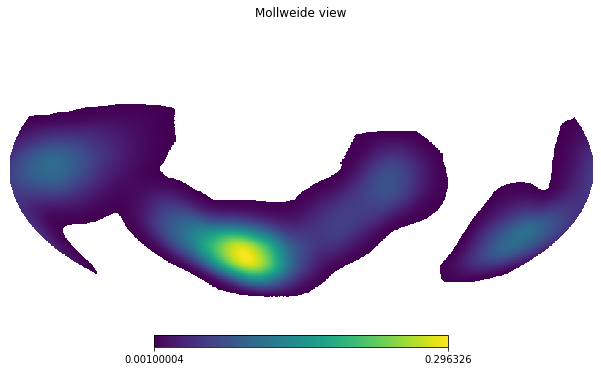

In [3]:
hp.mollview(np.where(mask_full>0.001,mask_full, np.inf))

setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]
setting the output map dtype to [dtype('float32')]


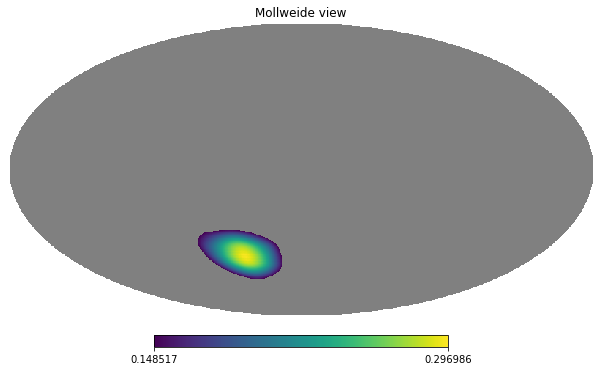

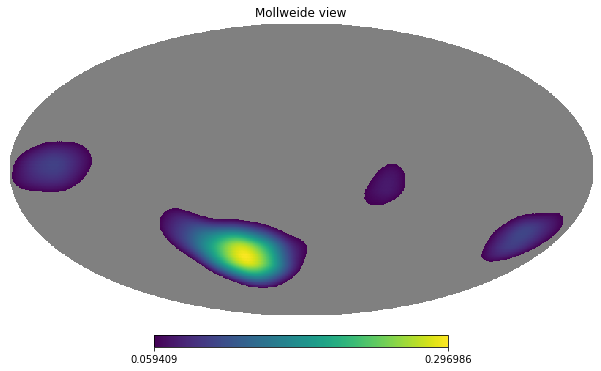

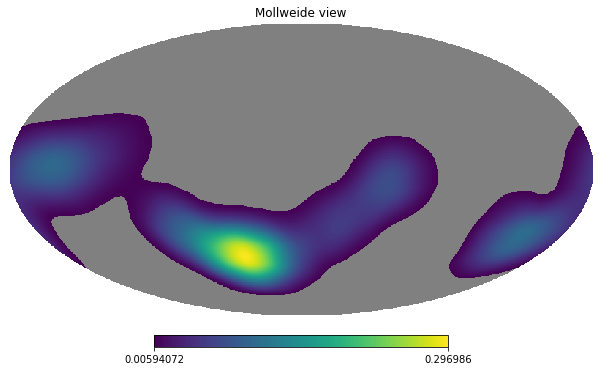

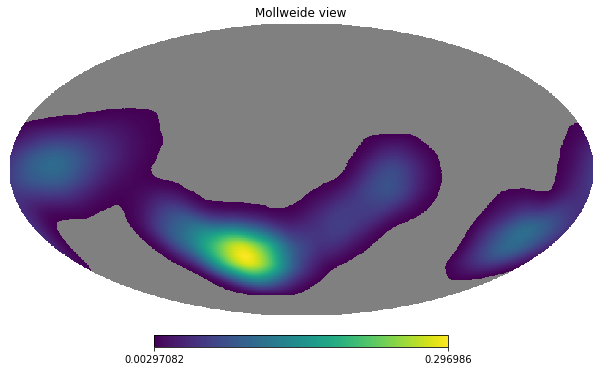

In [6]:
# mask = np.where(rhits < 1. / ratio, 0., rhits)  *(~np.isnan(rhits))
for n in [2,5,50,100]:
    mask = sc.get_nlev_mask(n)
    hp.mollview(np.where(mask==0,np.nan,mask))
    np.save('/global/homes/s/sebibel/git/lerepi/lerepi/data/dc08/masks/mask_r%s'%n, mask)
    hp.write_map('/global/homes/s/sebibel/git/lerepi/lerepi/data/dc08/masks/mask_r%s.fits'%n, mask)

## Check masks

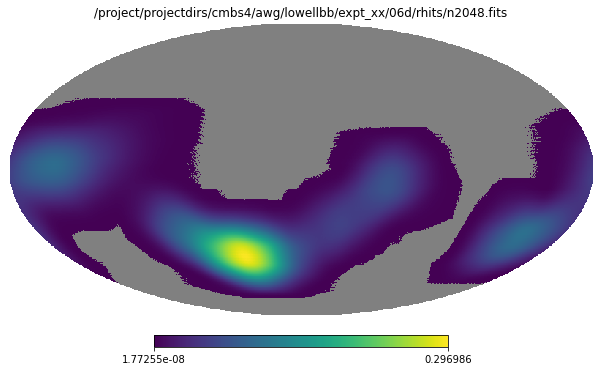

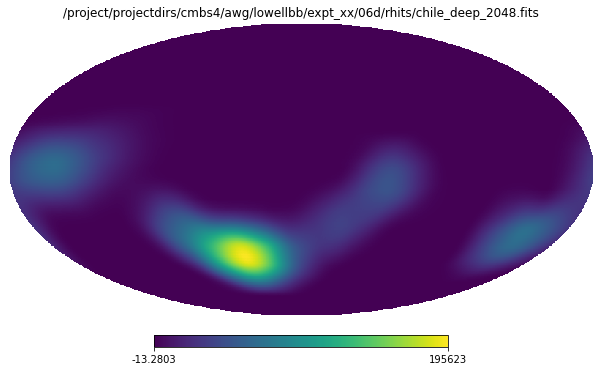

In [270]:
mask_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
mask_chiledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')
hp.mollview(mask_n2048, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
hp.mollview(mask_chiledeep, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')

In [276]:
NQU = sims_lerepi.get_noise_sim_pmap(0)

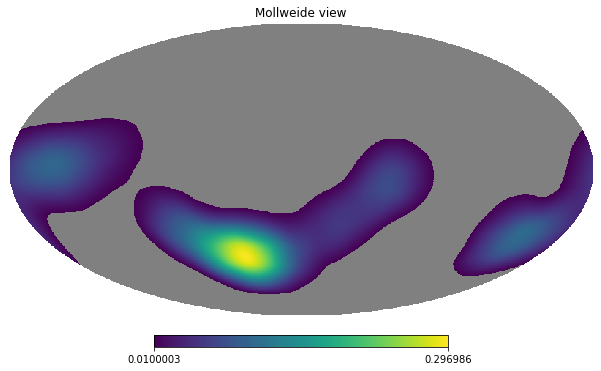

In [360]:
mask = np.where(mask_n2048<0.01,np.nan,mask_n2048) *(~np.isnan(mask_n2048))
hp.mollview(mask)

In [364]:
NQUlm_cm = hp.map2alm(NQU[0]*np.nan_to_num(mask))
NQUlm_cm_bp = bandpass_alms(NQUlm_cm,2,200)
NQU_bp = hp.alm2map(NQUlm_cm_bp, nside=2048)

KeyboardInterrupt: 

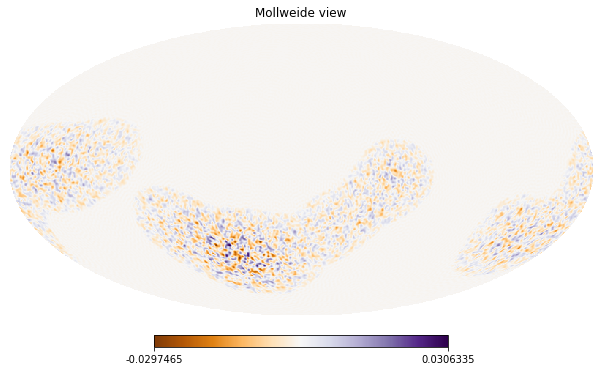

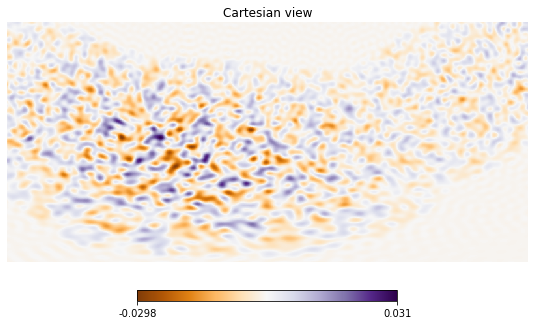

In [421]:
hp.mollview(NQU_bp, cmap='PuOr')
hp.cartview(NQU_bp, lonra=[-40,90], latra=[-70,-10], cmap='PuOr')

## Build noise template

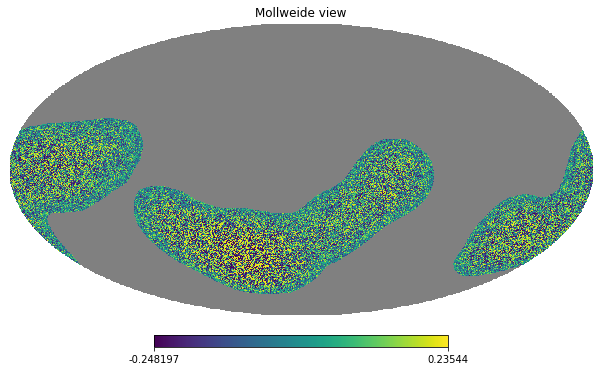

In [301]:
hp.mollview(NQU[0]*mask, norm='hist')

In [304]:
from scipy.signal import savgol_filter as sf
ClN_QU_cs_pospace = ps.map2cl(NQU[0], np.nan_to_num(mask), 2048, 4096)

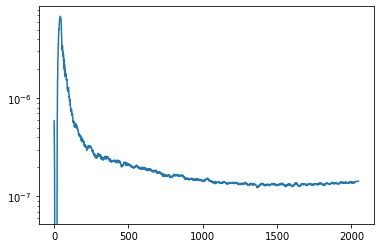

In [341]:
clN_templ = sf(ClN_QU_cs_pospace, 41, 3)/tf**2
clN_templ[clN_templ<0] = 0
plt.plot(clN_templ)
plt.yscale('log')
# plt.xlim((2,200))
# plt.ylim((1e-9,1e-5))

## Choose mask for central value

0.012869954109191895

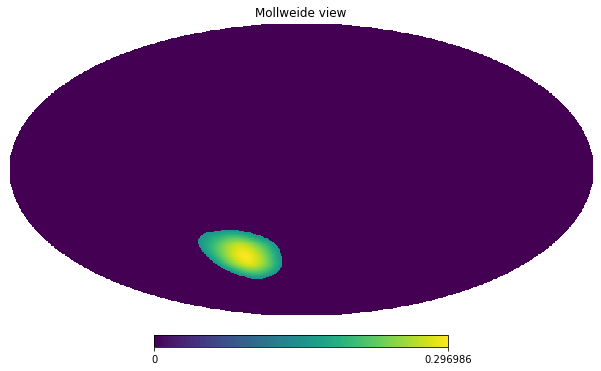

In [359]:
mask_center = np.where(mask>0.15,mask,0)
hp.mollview(mask_center)
np.sum(np.where(mask>0.20,1,0))/len(mask)

## Calculate

In [342]:
from component_separation.MSC.MSC import pospace as ps

cmbs4_edges = np.array([30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000])
edges_center = (cmbs4_edges[1:]+cmbs4_edges[:-1])/2
lmax_cl = 1024
lmax_lib = 2*lmax_cl-1
ClN_binned = ps.map2cl_binned(np.where(mask>0.15,mask,0), clN_templ, cmbs4_edges, lmax_lib)

Calculating coupling matrix...
zero ww at 43.2 deg
 [00:00:00]  ---------> 91%


In [346]:
ClN_binned_cs = ClN_binned.map2cl(NQU[0])/tf[[int(e) for e in edges_center]]**2

central noise level for s08d: 0.5901578150190856


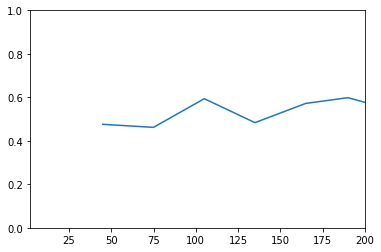

In [357]:
plt.plot(edges_center, ClN_binned_cs)
plt.xlim(2,200)
plt.ylim(0,1)
ClN_binned_cs
print('central noise level for s08d: {}'.format(ClN_binned_cs[-1]))

## Repeat this for s08b. Should lead to central noise level of 0.42 mu K arcmin

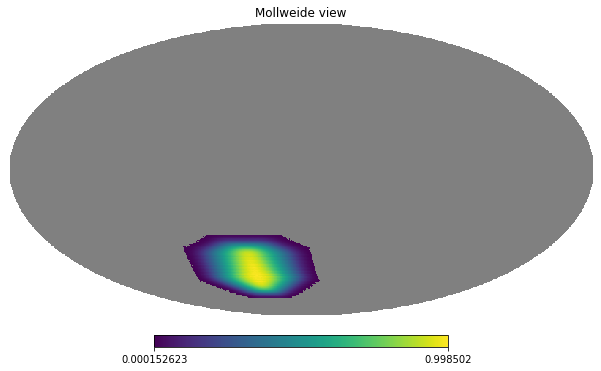

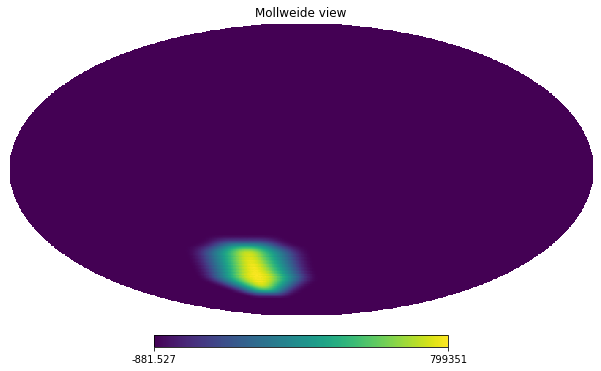

In [348]:
mask_poledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/pole_deep_2048.fits')
mask_pole_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/n2048.fits')
hp.mollview(mask_pole_n2048)
hp.mollview(mask_poledeep)

In [349]:
from lerepi.data.dc08b import sims_interface
sims_may  = sims_interface.caterinaILC_May12('00')
N_08b = sims_may.get_noise_sim_pmap(0)
mask_08b = hp.read_map(sims_may.p2mask)

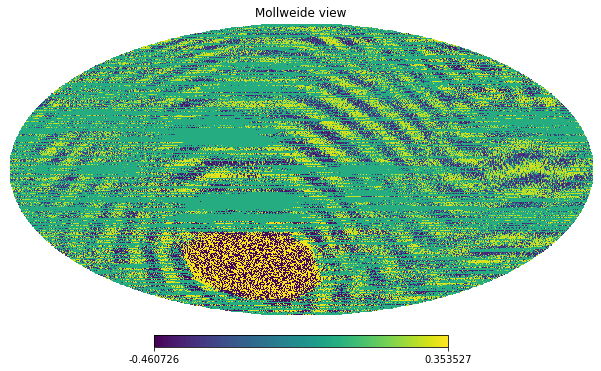

In [350]:
hp.mollview(N_08b[0]*mask_08b, norm='hist')

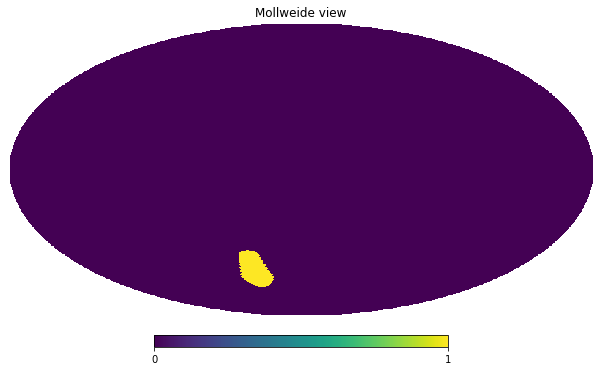

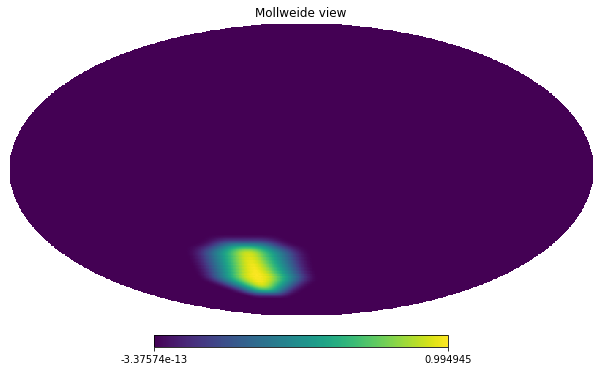

In [351]:
hp.mollview(small_mask_08b)
hp.mollview(mask_08b)

In [352]:
bin_lib = ps.map2cl_binned(small_mask_08b, np.where(clN_templ>0,clN_templ,0), cmbs4_edges, lmax_lib)
CN_08b_binned = bin_lib.map2cl(N_08b[0])
# CN_08b = ps.map2cl(N_08b[0], mask_08b, 1024, 2048)

Calculating coupling matrix...
zero ww at 22.5 deg
 [00:00:00]  ---------> 91%


Text(0, 0.5, '$C_l \\ell(\\ell+1)$/2$\\pi$')

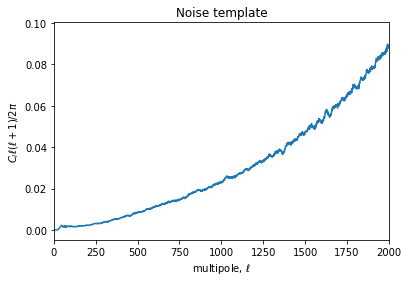

In [354]:
plt.plot(np.where(clN_templ>0,clN_templ,0)[:2048]*scale_ps)
plt.xlim(0,2000)
# plt.ylim(0,0.01)
plt.title('Noise template')
plt.xlabel('multipole, $\ell$')
plt.ylabel('$C_l \ell(\ell+1)$/2$\pi$')

Text(0, 0.5, '$C_l$')

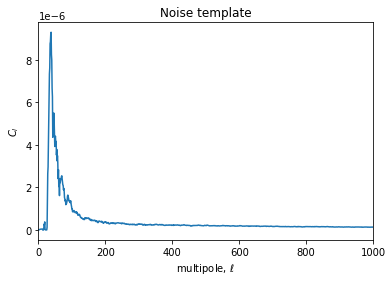

In [235]:
plt.plot(np.where(clN_templ>0,clN_templ,0)[:2048])
plt.xlim(0,1000)
# plt.ylim(0,0.01)
plt.title('Noise template')
plt.xlabel('multipole, $\ell$')
plt.ylabel('$C_l$')# \ell(\ell+1)$/2$\pi$')

array([1.44854309, 1.3326434 , 0.70026712, 0.98415927, 0.73168199,
       0.63509242, 0.57605411, 0.52560874, 0.45883315, 0.41120816,
       0.40906199])

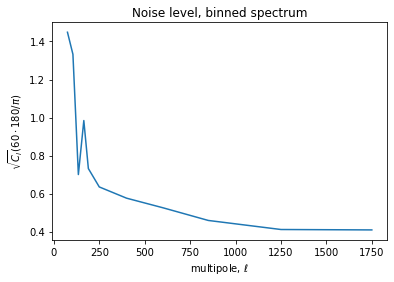

In [355]:
plt.plot(edges_center[1:], np.sqrt(CN_08b_binned[1:]*clN_templ[[int(e) for e in edges_center]][1:]) * (60 * 180 / np.pi))
plt.title('Noise level, binned spectrum')
plt.xlabel('multipole, $\ell$')
plt.ylabel('$\sqrt{C_l} (60 \cdot 180 / \pi)$')
np.sqrt(CN_08b_binned[1:]*clN_templ[[int(e) for e in edges_center]][1:]) * (60 * 180 / np.pi)